# Regularization

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import time
from sklearn.datasets import load_boston

In [2]:
boston_dataset = load_boston()
boston_df = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston_df['MEDV'] = boston_dataset.target
input_feature = 'RM'
target_feature = 'MEDV'
X = boston_df[[input_feature]]
y = boston_df[[target_feature]].values

/home/gabry/Dataspell/LinearRegression/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the Cal

## Gradient descent regularized (loop based)

$$J(\theta) = \frac{1}{2m} \sum_{i=0}^{m-1}  \Big[(h_{\theta} (x^{(i)}) - y^{(i)})^2 + \lambda \sum_{j=1}^{n} \theta_j^2\Big]$$

$$\theta_j := \theta_j - \frac{\alpha}{m} \Big[ \sum_{i=0}^{m-1}(h_{\theta} (x^{(i)}) - y^{(i)}) x_{j} + \lambda*\theta_j\Big]$$

In [3]:
def featureScaling(X):
    Z = np.copy(X)
    mu = np.mean(Z,axis=0)
    std = np.std(Z,axis=0)
    Z = (Z - mu)/std
    return Z

In [4]:
def polynomial_features(dataframe, degree):
    df = dataframe.copy()
    feature_name = dataframe.columns[0]
    for i in range(1,degree):
        key = "{}^{}".format(feature_name,i+1)
        df[key] = df[feature_name]**(i+1)
    return df

In [5]:
X_poly_2_scaled = featureScaling(polynomial_features(X,2))
X_poly_3_scaled = featureScaling(polynomial_features(X,3))
X_poly_4_scaled = featureScaling(polynomial_features(X,4))
X_poly_5_scaled = featureScaling(polynomial_features(X,5))
X_poly_6_scaled = featureScaling(polynomial_features(X,6))
X_poly_7_scaled = featureScaling(polynomial_features(X,7))
X_poly_8_scaled = featureScaling(polynomial_features(X,8))

In [6]:
X_linear = np.c_[np.ones((X.shape[0],1)), X]
X_poly_2_scaled_int = np.c_[np.ones((X_poly_2_scaled.shape[0],1)),X_poly_2_scaled]
X_poly_3_scaled_int = np.c_[np.ones((X_poly_3_scaled.shape[0],1)),X_poly_3_scaled]
X_poly_4_scaled_int = np.c_[np.ones((X_poly_4_scaled.shape[0],1)),X_poly_4_scaled]
X_poly_5_scaled_int = np.c_[np.ones((X_poly_5_scaled.shape[0],1)),X_poly_5_scaled]
X_poly_6_scaled_int = np.c_[np.ones((X_poly_6_scaled.shape[0],1)),X_poly_6_scaled]
X_poly_7_scaled_int = np.c_[np.ones((X_poly_7_scaled.shape[0],1)),X_poly_7_scaled]
X_poly_8_scaled_int = np.c_[np.ones((X_poly_8_scaled.shape[0],1)),X_poly_8_scaled]

In [7]:
def computeCostLoopBaseReg(X, y, theta = np.zeros((X.shape[1],1)), l = 0.0):
    m = X.shape[0]
    J = 0

    elapsed_time = -time.time()

    for i in range(m):
        h = 0
        for k in range(X.shape[1]):
            h += (theta[k]*X[i][k])
        J += ( h - y[i]) ** 2#individual loss of i-th element
    theta_reg = 0
    for j in range(1,X.shape[1]):
        theta_reg += theta[j]**2
    J += l*theta_reg
    J /= 2*m

    elapsed_time += time.time()
    elapsed_time_ms = np.round(elapsed_time*1000,3)

    return J, elapsed_time_ms

In [8]:
def gradientDescentLoopReg(X, y, theta = np.zeros((X.shape[1],1)), alpha = 0.001, n_iters = 1000, early = False, epsilon = 0.000001, l=0.0):
    m = X.shape[0]
    n = X.shape[1]
    J = np.zeros((n_iters,1))
    theta_history = []
    theta_gd = np.copy(theta)
    theta_mask = np.ones((n,1))
    theta_mask[0] = 0
    theta_history.append(theta)

    elapsed_time = -time.time()
    for iter in range(n_iters):
        prev = J[iter -1]
        J[iter],_= computeCostLoopBaseReg(X,y,theta_gd,l=l)
        #stdout.write("\rIteration {}/{} Cost: {} Loss: {}".format(iter,n_iters,J[iter], prev-J[iter]))

        h = np.zeros((m,1))
        partial_sum = np.zeros((n,1))
        for i in range(m):
            for j in range(n):
                h[i] += theta_gd[j]*X[i][j]
            for j in range(n):
                partial_sum[j] += (h[i] - y[i])*X[i][j]
        for j in range(n):
            theta_gd[j] = theta_gd[j] - (alpha/m)*(partial_sum[j] + l*theta_gd[j]*theta_mask[j])

        theta_history.append(np.copy(theta_gd))

        if early:
            if (iter != 0) and (J[iter -1 ] - J[iter] < epsilon):
                elapsed_time += time.time()
                elapsed_time = np.round(elapsed_time*1000,3)
                #stdout.write("\n")
                return theta_gd,J[J!=0],elapsed_time,theta_history

    elapsed_time += time.time()
    elapsed_time = np.round(elapsed_time*1000,3)
    #stdout.write("\n")
    return theta_gd,J,elapsed_time,theta_history

In [9]:
computeCostLoopBaseReg(X_poly_2_scaled_int,y,theta=np.zeros((X_poly_2_scaled_int.shape[1],1)),l=0.1)

(array([296.0734585]), 7.178)

In [10]:
gradientDescentLoopReg(X_poly_2_scaled_int, y, theta = np.zeros((X_poly_2_scaled_int.shape[1],1)), alpha = 0.001, n_iters = 1000, early = False, epsilon = 0.001, l=0.1)

(array([[14.24759653],
        [ 2.70894814],
        [ 2.91792788]]),
 array([[296.0734585 ],
        [295.48170928],
        [294.8913103 ],
        [294.30225818],
        [293.71454958],
        [293.12818113],
        [292.5431495 ],
        [291.95945137],
        [291.37708341],
        [290.79604231],
        [290.21632478],
        [289.63792752],
        [289.06084724],
        [288.48508068],
        [287.91062458],
        [287.33747566],
        [286.7656307 ],
        [286.19508644],
        [285.62583967],
        [285.05788716],
        [284.4912257 ],
        [283.9258521 ],
        [283.36176315],
        [282.79895568],
        [282.23742651],
        [281.67717247],
        [281.11819041],
        [280.56047717],
        [280.00402962],
        [279.44884463],
        [278.89491906],
        [278.34224982],
        [277.79083379],
        [277.24066788],
        [276.69174899],
        [276.14407406],
        [275.59764   ],
        [275.05244375],
        [274.5084

##  Vectorized

$$J(\theta) = \frac{1}{2m} \Big[(X\theta -y)^t (X\theta-y) + \lambda \theta_{r}^T\theta_{r} \Big]$$
$$\theta := \theta - \frac{\alpha}{m}\Big[ X^T(X\theta -y) + \lambda\theta_r \Big]$$

In [11]:
def computeCostVectorizedReg(X, y, theta = np.zeros((X.shape[1],1)), l = 0.0):
    J = 0
    m = X.shape[0]
    elapsed_time = -time.time()
    J = 1/(2*m) * ((X.dot(theta) - y).T.dot(X.dot(theta) - y) + l*theta[1:].T.dot(theta[1:]))
    elapsed_time += time.time()
    elapsed_time_ms = np.round(elapsed_time*1000,3)
    return J,elapsed_time_ms

In [20]:
def gradientDescentVectorizedReg(X, y, theta = np.zeros((X.shape[1],1)), alpha = 0.001, n_iters = 1000, early = False, epsilon = 0.001, l=0.0):
    m = X.shape[0]
    n = X.shape[1]
    J = np.zeros((n_iters,1))
    theta_history = []
    theta_gd = np.copy(theta)

    theta_history.append(theta)

    elapsed_time = -time.time()
    for iter in range(n_iters):
        J[iter],_= computeCostVectorizedReg(X,y,theta_gd,l=l)

        theta_gd = theta_gd - (alpha/m) * (X.T.dot(X.dot(theta_gd) -y) + l*np.r_[[[0]],theta_gd[1:]].reshape(-1,1))

        theta_history.append(np.copy(theta_gd))

        if early:
            if (iter != 0) and (J[iter -1 ] - J[iter] < epsilon):
                elapsed_time += time.time()
                elapsed_time = np.round(elapsed_time*1000,3)
                #stdout.write("\n")
                return theta_gd,J[J!=0],elapsed_time,theta_history

    elapsed_time += time.time()
    elapsed_time = np.round(elapsed_time*1000,3)
    #stdout.write("\n")
    return theta_gd,J,elapsed_time,theta_history

In [13]:
computeCostVectorizedReg(X_poly_2_scaled_int, y, theta = np.zeros((X_poly_2_scaled_int.shape[1],1)), l = 0.1)

(array([[296.0734585]]), 0.793)

In [22]:
gradientDescentVectorizedReg(X, y, theta = np.zeros((X.shape[1],1)), alpha = 0.001, n_iters = 1000, early = False, epsilon = 0.001, l=0.1)

(          0
 RM  3.65335,
 array([[296.0734585 ],
        [275.15646623],
        [255.87893742],
        [238.11237173],
        [221.73834064],
        [206.64769797],
        [192.73985238],
        [179.92209681],
        [168.10899055],
        [157.22178969],
        [147.18792223],
        [137.94050431],
        [129.41789441],
        [121.56328245],
        [114.32431106],
        [107.65272666],
        [101.50405772],
        [ 95.83731841],
        [ 90.6147353 ],
        [ 85.80149566],
        [ 81.36551536],
        [ 77.27722498],
        [ 73.50937278],
        [ 70.03684296],
        [ 66.8364883 ],
        [ 63.88697585],
        [ 61.16864471],
        [ 58.66337503],
        [ 56.35446713],
        [ 54.22653029],
        [ 52.26538008],
        [ 50.45794385],
        [ 48.79217357],
        [ 47.25696555],
        [ 45.84208636],
        [ 44.5381047 ],
        [ 43.33632847],
        [ 42.22874687],
        [ 41.20797697],
        [ 40.2672145 ],
        [ 39.

## Normal Equation Regularized

$$\large \theta = (X^TX + \lambda *I_r)^{-1} X^Ty$$

In [26]:
def normalEquationReg(X,y, l =0.0):
    Ir = np.identity(X.shape[1])
    Ir[0][0] = 0
    etime = -time.time()
    theta = np.linalg.inv(X.T.dot(X) + l*Ir).dot(X.T).dot(y)
    etime += time.time()
    etime = np.round(etime*1000,3)
    return theta, etime

In [28]:
normalEquationReg(X_poly_2_scaled_int,y, l =0.1)

(array([[ 22.53280632],
        [-15.22662946],
        [ 21.73756119]]),
 1.125)

## Effects of the regularization

In [58]:
theta_gd,_,_,theta_hist =gradientDescentVectorizedReg(X_poly_5_scaled_int, y, theta = np.zeros((X_poly_5_scaled_int.shape[1],1)), alpha = 0.001, n_iters = 1000, early = False, epsilon = 0.001, l=1000000)

In [56]:
theta_0 = []
theta_1 = []
theta_2 = []
theta_3 = []
theta_4 = []
theta_5 = []

for i in theta_hist:
    theta_0.append(i[0])
    theta_1.append(i[1])
    theta_2.append(i[2])
    theta_3.append(i[3])
    theta_4.append(i[4])
    theta_5.append(i[5])

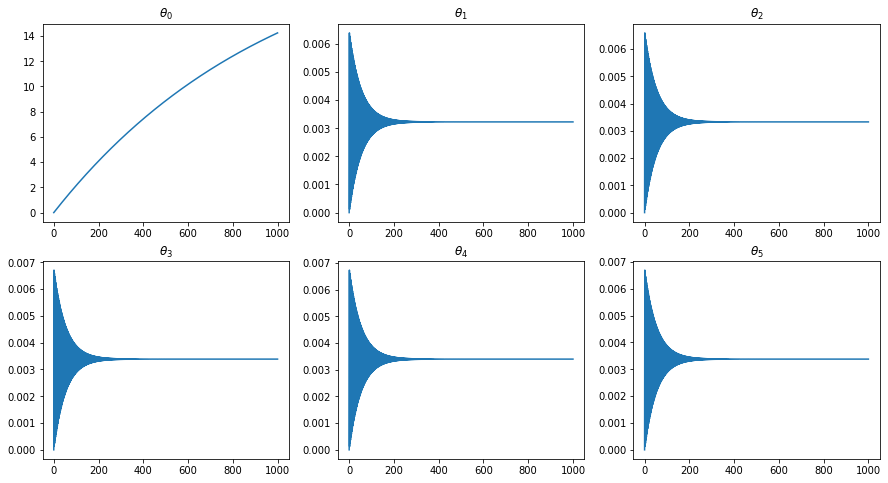

In [57]:
fig = plt.figure(figsize=(15,8))
ax11 = fig.add_subplot(2,3,1)
ax11.plot(theta_0)
ax11.set_title(r'$\theta_0$')
ax12 = fig.add_subplot(2,3,2)
ax12.plot(theta_1)
ax12.set_title(r'$\theta_1$')
ax13 = fig.add_subplot(2,3,3)
ax13.plot(theta_2)
ax13.set_title(r'$\theta_2$')
ax21 = fig.add_subplot(2,3,4)
ax21.plot(theta_3)
ax21.set_title(r'$\theta_3$')
ax22 = fig.add_subplot(2,3,5)
ax22.plot(theta_4)
ax22.set_title(r'$\theta_4$')
ax23 = fig.add_subplot(2,3,6)
ax23.plot(theta_5)
ax23.set_title(r'$\theta_5$')


plt.show()

## Plotting theta

In [66]:
X_5,yhat_5 = zip(*sorted(zip(X.values, X_poly_5_scaled_int.dot(theta_gd))))

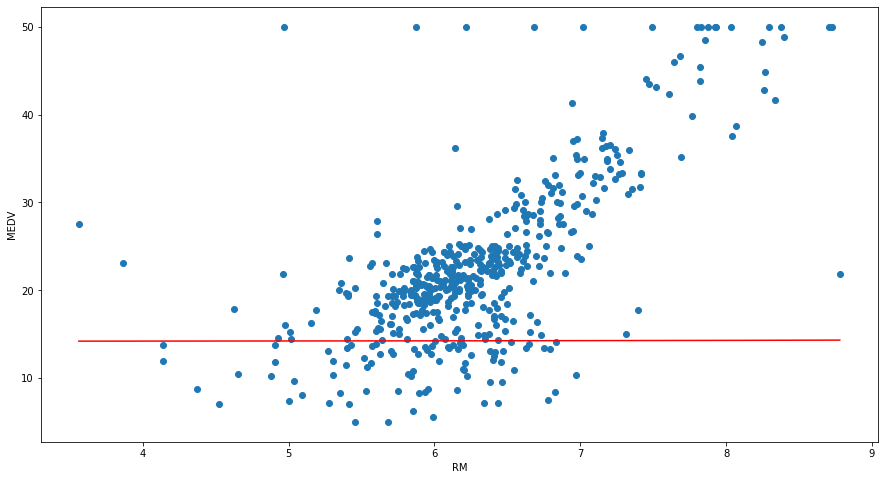

In [67]:
plt.figure(figsize=(15,8))

plt.scatter(X,y)
plt.xlabel(input_feature)
plt.ylabel(target_feature)

plt.plot(X_5, yhat_5, c='r')
plt.show()